In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect CT to be upside-down so we will not flip vertically

datagen_test = ImageDataGenerator(samplewise_center=True) # set each sample mean to 0

## remember to pre-process the image used for "prediction" the same way as images were pre-processed for training/validation
## since I missed it earlier, my validation score was very good but predictions terrible. I had missed the samplewise_center=True.
## this is a true pre-processing step.
## the others like rotation etc. are for augmentation. so it should not be used on a predicting image. 

## the datagen DOES NOT provide original images.. It REPLACES every input with the random transformation
## it DOES NOT provide additional images than original dataset either

In [19]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/home/jupyter/data/original-clahe/clahe/train/', 
                                       target_size=(128, 128), 
                                       color_mode='rgb', 
                                       class_mode='categorical', 
                                       batch_size=32,
                                       shuffle=True,
                                       seed=101)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/home/jupyter/data/original-clahe/clahe/valid', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode='categorical', 
                                      batch_size=100,
                                      shuffle=True,
                                      seed = 101)

# load and iterate test dataset
test_it = datagen_test.flow_from_directory('/home/jupyter/data/original-clahe/clahe/test', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode='categorical', ## this still has to be given since evaluate actually compares with actual
                                      batch_size=1)

# load and iterate test dataset
test_one = datagen_test.flow_from_directory('/home/jupyter/data/original-clahe/clahe/test_one', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode=None,  ## for prediction this is like totally unseen.. we don't know the actual
                                      shuffle=False, ## this is to match test_one.filenames[i] = predictions[i]; else predictions will return random orders everytime      
                                      batch_size=1)

## V.IMP there has to be atleast ONE sub-folder inside the test_one. doesn't have to be named after classes or have any relation.
## because then it will be 1 class or it will be like 0 class.. see below result.. found 1 image belonging to 1 class

## remove the hidden .ipynb_checkpoints folder if it identifies extra 1 class in a folder
## ls -a
## rmdir .ipynb_checkpoints/

Found 15747 images belonging to 3 classes.
Found 3923 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 1 images belonging to 1 classes.


In [20]:
labels = (train_it.class_indices)
labels

{'NiCT': 0, 'nCT': 1, 'pCT': 2}

In [21]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'NiCT', 1: 'nCT', 2: 'pCT'}

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Dropout,
    Flatten,
    BatchNormalization,
    GlobalAveragePooling2D,
    MaxPool2D
)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", input_shape = (128, 128, 3)))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=3, activation="softmax"))

## lower resolution 128, 128 actually worked better than 256,256... dont overburden the model
## model can see better than human eyes.. start low and then increase nodes, layers only if necessary

In [23]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 256)      

In [25]:
# steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator. (this is best rule)
# validation_data=(x_valid, y_valid)) # if needed even valid data can be passed through the datagen.
# validation steps also use same logic, although it is not clear 
# when using datagens for any iterator the #steps have to be explicitly defined for it.
## too many epochs can overfit

model.fit(train_it, steps_per_epoch=492, validation_data=valid_it, validation_steps=39, epochs=10, workers=4)

Epoch 1/10
492/492 [==============================] - 101s 206ms/step - loss: 41.8836 - accuracy: 0.6511 - val_loss: 0.3539 - val_accuracy: 0.8403
Epoch 2/10
492/492 [==============================] - 95s 192ms/step - loss: 0.3334 - accuracy: 0.8804 - val_loss: 0.1853 - val_accuracy: 0.9344
Epoch 3/10
492/492 [==============================] - 84s 170ms/step - loss: 0.3319 - accuracy: 0.9091 - val_loss: 0.1759 - val_accuracy: 0.9379
Epoch 4/10
492/492 [==============================] - 84s 171ms/step - loss: 0.3768 - accuracy: 0.9220 - val_loss: 0.3280 - val_accuracy: 0.9333
Epoch 5/10
492/492 [==============================] - 83s 169ms/step - loss: 0.2561 - accuracy: 0.9262 - val_loss: 0.2361 - val_accuracy: 0.9241
Epoch 6/10
492/492 [==============================] - 84s 170ms/step - loss: 0.2443 - accuracy: 0.9271 - val_loss: 0.2075 - val_accuracy: 0.9482
Epoch 7/10
492/492 [==============================] - 84s 170ms/step - loss: 0.2578 - accuracy: 0.9285 - val_loss: 0.2150 - val_

In [26]:
history = model.history

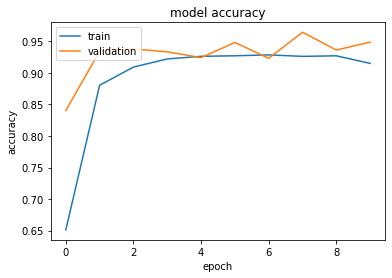

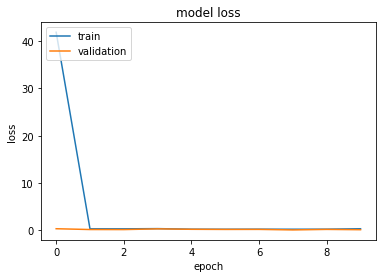

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
model.save('ctscan_original_clahe_model')

INFO:tensorflow:Assets written to: ctscan_original_clahe_model/assets


In [11]:
from tensorflow import keras
model = keras.models.load_model('ctscan_original_model')

In [29]:
model.evaluate(test_it) 

## remember to run the datagen flow i.e train_it, test_it etc. before predictions. 
## it reads the files then. basically reset if anything changed in the input.

15/15 [==============================] - 0s 10ms/step - loss: 0.7005 - accuracy: 0.9333


[0.7004546523094177, 0.9333333373069763]

In [30]:
# when only one file is present
print(test_one.samples)
predictions = model.predict(test_one)
print(predictions)
print('Predicted Class:', labels[np.argmax(predictions)])

1
[[0.00257778 0.00151165 0.9959105 ]]
Predicted Class: pCT


In [31]:
## GENERIC prediction: when more than 1 file were present
## pCT000 is actually a NiCT file..just to see how it predicts it was renamed!!
print('# of files', test_one.samples)
predictions = model.predict(test_one) ## one by one predicts all the files..the shuffle will make the order random, so shuffle=False in datagen
print(predictions)
for i in range(test_one.samples):
    print(test_one.filenames[i], 'predicted:', labels[np.argmax(predictions[i])])

# of files 1
[[0.00257778 0.00151165 0.9959105 ]]
ct_scans/pCT1086.jpg predicted: pCT


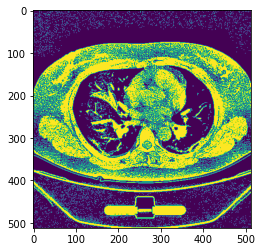

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('/home/jupyter/data/original-clahe/clahe/test_one/ct_scans/pCT1086.jpg')
plt.imshow(image)

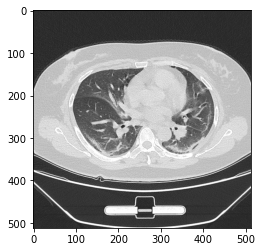

In [42]:
image = mpimg.imread('/home/jupyter/data/Original/valid/pCT/pCT1086.jpg')
plt.imshow(image)